IGNORING WARNINGS

In [35]:
from warnings import filterwarnings
filterwarnings('ignore')

IMPORTING & CHECKING DATASET

In [36]:
import pandas as pd
df=pd.read_csv('train_titanic.csv')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [38]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [39]:
m = df.isna().sum()

SEPERATING X AND Y

In [40]:
x = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'])
y = df[['Survived']]

In [41]:
x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [42]:
y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


PERFORMING CAT CON SEPERATION

In [43]:
cat = list(x.columns[x.dtypes=='object'])
con = list(x.columns[x.dtypes!='object'])

In [44]:
cat

['Sex', 'Embarked']

In [45]:
con

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

CREATING A PIPELINE FOR FEATURE SELECTION

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [47]:
num_pipe1 = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                           ('scaler', StandardScaler())])

In [48]:
cat_pipe1 = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                           ('ohe', OrdinalEncoder())])

In [49]:
pre1 = ColumnTransformer([('num', num_pipe1, con),
                         ('cat', cat_pipe1, cat)]).set_output(transform='pandas')

In [50]:
pre1

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe', OrdinalEncoder())]),
                                 ['Sex', 'Embarked'])])

In [51]:
x_pre = pre1.fit_transform(x)
x_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex,cat__Embarked
0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,1.0,2.0
1,-1.566107,0.663861,0.432793,-0.473674,0.786845,0.0,0.0
2,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,0.0,2.0
3,-1.566107,0.433312,0.432793,-0.473674,0.420730,0.0,2.0
4,0.827377,0.433312,-0.474545,-0.473674,-0.486337,1.0,2.0


PERFORMING FEATURE SELECTION WITH MUTUAL INFORMATION SCORES

In [52]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(x_pre, y)
mi

array([0.04276069, 0.03315866, 0.00919481, 0.0408596 , 0.11995026,
       0.15588749, 0.        ])

In [53]:
mi = pd.Series(mi)
mi.index = x_pre.columns
mi = mi.sort_values(ascending=False)
mi

cat__Sex         0.155887
num__Fare        0.119950
num__Pclass      0.042761
num__Parch       0.040860
num__Age         0.033159
num__SibSp       0.009195
cat__Embarked    0.000000
dtype: float64

<Axes: title={'center': 'MUTUAL INFORMATION SCORES'}>

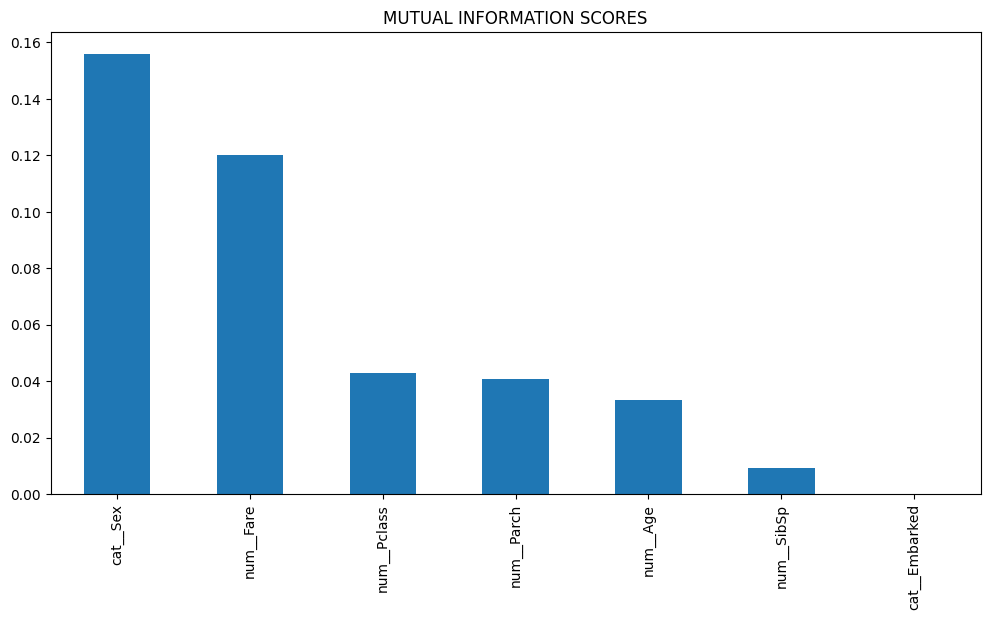

In [54]:
mi.plot(kind='bar', title='MUTUAL INFORMATION SCORES', figsize=(12, 6))

SELECTING TOP 5 FEATURE

In [55]:
from sklearn.feature_selection import SelectKBest
sel = SelectKBest(mutual_info_classif, k=5)
sel.fit(x_pre, y)
sel_cols = sel.get_feature_names_out()
sel_cols

array(['num__Pclass', 'num__SibSp', 'num__Parch', 'num__Fare', 'cat__Sex'],
      dtype=object)

GETTING ORIGINAL COLUMN NAMES

In [56]:
sel_cols[0].split('__')

['num', 'Pclass']

In [57]:
sel_cols[0].split('__')[1]

'Pclass'

In [58]:
imp_cols = []
for i in sel_cols:
    s = i.split('__')[1]
    imp_cols.append(s)

In [59]:
imp_cols

['Pclass', 'SibSp', 'Parch', 'Fare', 'Sex']

In [60]:
x_imp = x[imp_cols]
x_imp

,Pclass,SibSp,Parch,Fare,Sex
0,3,1,0,7.2500,male
1,1,1,0,71.2833,female
2,3,0,0,7.9250,female
3,1,1,0,53.1000,female
4,3,0,0,8.0500,male
...,...,...,...,...,...
886,2,0,0,13.0000,male
887,1,0,0,30.0000,female
888,3,1,2,23.4500,female
889,1,0,0,30.0000,male
